In [154]:
import numpy as np
import os
import pandas as pd
import random
from collections import defaultdict
import gym
import gym_minigrid
import matplotlib.pyplot as plt
%matplotlib inline

In [155]:
class SARSA:
    def __init__(self, actions, agent_indicator=10):
        self.actions = actions
        self.agent_indicator = agent_indicator
        self.alpha = 0.01
        self.gamma = 0.9
        self.epsilon = 0.2
        self.q_values = defaultdict(lambda: [0.0] * actions)
        
    def _convert_state(self, s):
        return np.where(s == self.agent_indicator)[0][0]
        
    def update(self, state, action, reward, next_state, next_action):
        state = self._convert_state(state)
        next_state = self._convert_state(next_state)
        
        q_value = self.q_values[state][action]
        
        ################ Write Code #####################
        next_q_value = self.q_values[next_state][next_action]
        
        td_error = reward + self.gamma * next_q_value - q_value
        self.q_values[state][action] = q_value + self.alpha * td_error
        #################################################
    
    def act(self, state):
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.actions)
        else:
            state = self._convert_state(state)
            q_values = self.q_values[state]
            action = np.argmax(q_values)
        return action

In [156]:
from utils import gen_wrapped_env, show_video

In [157]:
from gym.wrappers import TimeLimit

env = gen_wrapped_env('MiniGrid-Empty-6x6-v0')

env = TimeLimit(env, max_episode_steps=1000)

obs = env.reset()

agent_position = obs[0]

agent = SARSA(3, agent_position)

## For Sarsa
+ Sarsa update

In [158]:
rewards = []
for ep in range(50000):
    done = False
    obs = env.reset()
    action = agent.act(obs)
    
    ep_rewards = 0
    while not done:
        next_obs, reward, done, info = env.step(action)

        next_action = agent.act(next_obs)

        agent.update(obs, action, reward, next_obs, next_action)
        
        ep_rewards += reward
        obs = next_obs
        action = next_action
    rewards.append(ep_rewards)
    if (ep+1) % 20 == 0:
        print("episode: {}, rewards: {}".format(ep+1, ep_rewards))
env.close()

episode: 20, rewards: 0
episode: 40, rewards: 0
episode: 60, rewards: 0
episode: 80, rewards: 0
episode: 100, rewards: 0
episode: 120, rewards: 0
episode: 140, rewards: 0
episode: 160, rewards: 0
episode: 180, rewards: 0
episode: 200, rewards: 0
episode: 220, rewards: 0
episode: 240, rewards: 0
episode: 260, rewards: 0
episode: 280, rewards: 0
episode: 300, rewards: 0
episode: 320, rewards: 0
episode: 340, rewards: 0
episode: 360, rewards: 0
episode: 380, rewards: 0
episode: 400, rewards: 0
episode: 420, rewards: 0
episode: 440, rewards: 0
episode: 460, rewards: 0
episode: 480, rewards: 0
episode: 500, rewards: 0
episode: 520, rewards: 0
episode: 540, rewards: 0
episode: 560, rewards: 0
episode: 580, rewards: 0
episode: 600, rewards: 0
episode: 620, rewards: 0
episode: 640, rewards: 0
episode: 660, rewards: 0
episode: 680, rewards: 0
episode: 700, rewards: 0
episode: 720, rewards: 0
episode: 740, rewards: 0
episode: 760, rewards: 0
episode: 780, rewards: 0
episode: 800, rewards: 0
epis

In [159]:
{s:np.round(q, 5).tolist() for s, q in agent.q_values.items()}

{0: [0.01723, 0.01703, 0.0209],
 3: [0.0049, 0.00531, 0.01363],
 12: [0.0281, 0.02875, 0.04068],
 15: [0.0047, 0.00542, 0.04445],
 24: [0.04357, 0.04311, 0.06106],
 6: [0.00748, 0.0073, 0.01797],
 9: [0.01755, 0.01798, 0.02191],
 27: [0.01963, 0.01676, 0.13825],
 36: [0.06715, 0.06633, 0.07451],
 39: [0.23285, 0.21894, 0.36669],
 30: [0.02348, 0.03088, 0.22801],
 18: [0.00761, 0.00803, 0.08183],
 21: [0.06766, 0.06871, 0.11903],
 33: [0.1801, 0.16863, 0.28559],
 42: [0.35668, 0.33106, 0.53108],
 45: [0.0, 0.0, 0.0]}

In [160]:
show_video()

In [161]:
os.makedirs('./logs', exist_ok=True)
pd.Series(rewards).to_csv('./logs/rewards_sarsa.csv')

In [162]:
sarsa_logs = pd.read_csv('./logs/rewards_sarsa.csv', index_col=False).iloc[:, 1]
q_logs = pd.read_csv('./logs/rewards_qlearning.csv', index_col=False).iloc[:, 1]

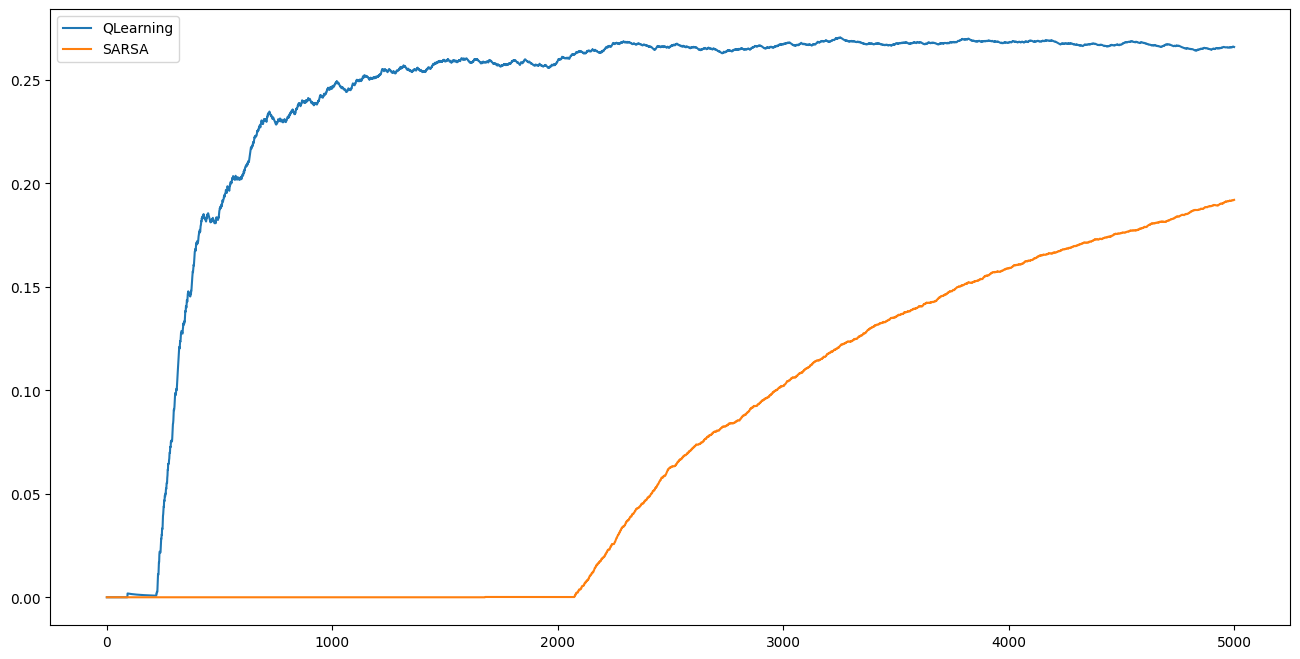

In [163]:
plt.figure(figsize=(16, 8))
plt.plot(q_logs.cumsum() / (pd.Series(np.arange(q_logs.shape[0]))+1), label="QLearning")
plt.plot(sarsa_logs.cumsum() / (pd.Series(np.arange(sarsa_logs.shape[0]))+1), label="SARSA")
plt.legend()